# Pytorch Workflow Fundamentals

In [1]:
import torch
from torch import nn 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
workflow = {1: "data (prepare and load)",
            2: "build model",
            3: "fitting the model to data (training)",
            4: "making predictions and evaluvating a model (inference)",
            5: "saving and loading a model",
            6: "putting it all together"}

workflow

## 1. Data (Preparing and Loading)

1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation

Creating some known data using the linear regression formula
We'll use a linear regression formula to make a straight line with known **parameters**

In [2]:
# known parameters
weight = 0.7
bias = 0.3

#create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Splitting data into training and testing sets

In [3]:
len(X), len(y)

(50, 50)

In [4]:
# Train / Test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

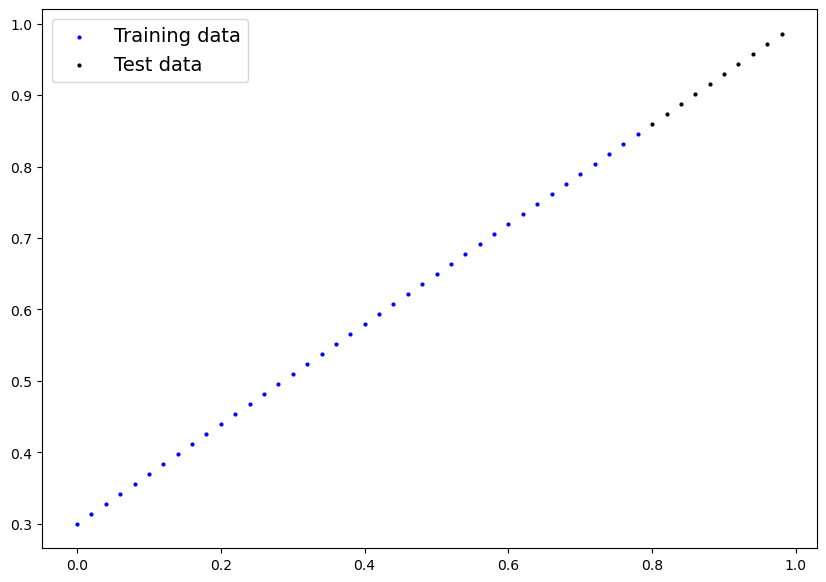

In [5]:
def plot_predictions (train_data = X_train,
                      train_labels = y_train,
                      test_data = X_test,
                      test_labels = y_test,
                      predictions = None):
    
    plt.figure(figsize=(10,7))

    plt.scatter(train_data, train_labels, c='b', s=4, label = "Training data")

    plt.scatter(test_data, test_labels, c='k', s=4, label = "Test data")

    if predictions is not None:

        plt.scatter(test_data, predictions, c='r', s = 4, label="Predictions")

    plt.legend(prop={"size": 14})


plot_predictions()

## 2. Build Model

What the model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal valuse (the weight & bias values we used to create the data)


Through two main algorithms:
1. Gradient Descent
2. Backpropagation

In [6]:
# Linear Regression model class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.rand(1, dtype = torch.float, requires_grad=True))

        self.bias = nn.Parameter(torch.rand(1, dtype = torch.float, requires_grad=True))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias        

#### Pytorch Model Building Essentials
* torch.nn - contains all of the building blocks for computational graphs
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set this
* torch.nn.Module - the base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclass require you to overwrite forward(), this method defines what happens in the forward computation

we can check our model parameters or what's inside our model using `.parameters()`

In [7]:
torch.manual_seed(42)

# creating an instance of the model 
model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([0.9150], requires_grad=True)]

In [8]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([0.9150]))])

In [9]:
weight, bias

(0.7, 0.3)

In [10]:
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[1.6208],
        [1.6385],
        [1.6561],
        [1.6738],
        [1.6914],
        [1.7090],
        [1.7267],
        [1.7443],
        [1.7620],
        [1.7796]])

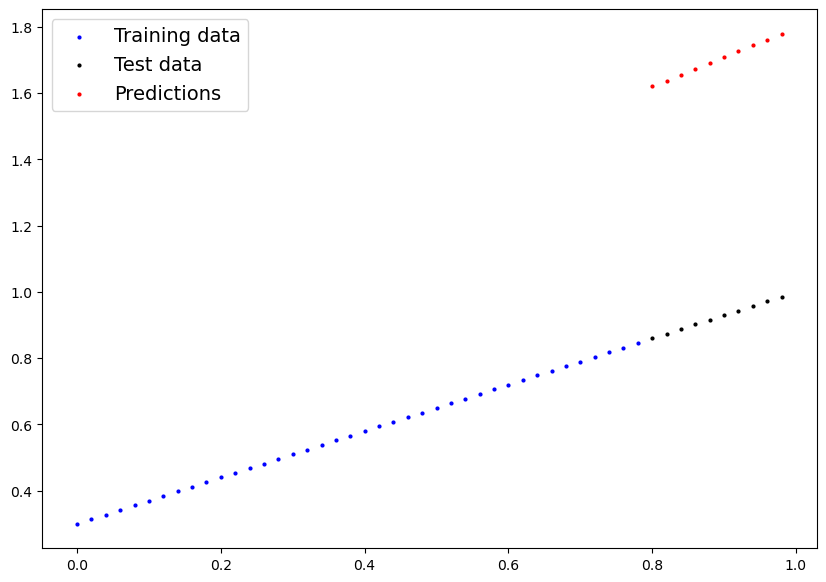

In [11]:
plot_predictions(predictions=y_preds)

In [ ]:
y_test - y_preds

## 3. Train Model

One way to measure how poor or how wrong the models predictions are is to use a loss function.

Things we have to train:

* **Loss Function** - A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
aka cost function or criterion.
* **Optimizer** - Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias) to improve the loss function.
    * Inside the optimizer you'll often have to set two parameters:
        * `params` - the model parameters you'd like to optimize
        * `lr` - the learning rate, a hyperparameter that defines how big/small the optimizer changes the parameters with each step

In [12]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([0.9150], requires_grad=True)]

In [13]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([0.9150]))])

In [14]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an Optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr = 0.01)


#### Building a training loop (and Testing loop)

Things we need to do in a training loop:
0. Loop through the data
1. Forward pass (data moving through the model's `forward()` function) to make predictions on data - aka forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model wrt the loss. (backpropogation)
5. Optimizer step - use the optimizer to adjust the model's parameters and try to improve the loss(gradient descent)

In [ ]:
list(model_0.parameters())

In [15]:
epochs = 100

train_lost_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    model_0.train()

    # 1. Forward Pass
    y_pred = model_0(X_train)

    # 2. Calculate the Loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss wrt parameters of the model
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    model_0.eval()  

    with torch.inference_mode():

        # 1. Forward Pass on test data
        test_pred = model_0(X_test)

        # 2. Calculate loss on test data
        test_loss = loss_fn(test_pred, y_test.type(torch.float))

        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_lost_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")
            print(model_0.state_dict())

Epoch: 0 | MAE Train Loss: 0.6860889196395874 | MAE Test Loss: 0.7637526988983154 
OrderedDict([('weights', tensor([0.8784])), ('bias', tensor([0.9050]))])
Epoch: 10 | MAE Train Loss: 0.5708791017532349 | MAE Test Loss: 0.6290428042411804 
OrderedDict([('weights', tensor([0.8394])), ('bias', tensor([0.8050]))])
Epoch: 20 | MAE Train Loss: 0.45566922426223755 | MAE Test Loss: 0.4943329691886902 
OrderedDict([('weights', tensor([0.8004])), ('bias', tensor([0.7050]))])
Epoch: 30 | MAE Train Loss: 0.34045934677124023 | MAE Test Loss: 0.35962313413619995 
OrderedDict([('weights', tensor([0.7614])), ('bias', tensor([0.6050]))])
Epoch: 40 | MAE Train Loss: 0.2252494841814041 | MAE Test Loss: 0.2249133139848709 
OrderedDict([('weights', tensor([0.7224])), ('bias', tensor([0.5050]))])
Epoch: 50 | MAE Train Loss: 0.1100396141409874 | MAE Test Loss: 0.09020347893238068 
OrderedDict([('weights', tensor([0.6834])), ('bias', tensor([0.4050]))])
Epoch: 60 | MAE Train Loss: 0.009724985808134079 | MAE 

## 4. Making predictions

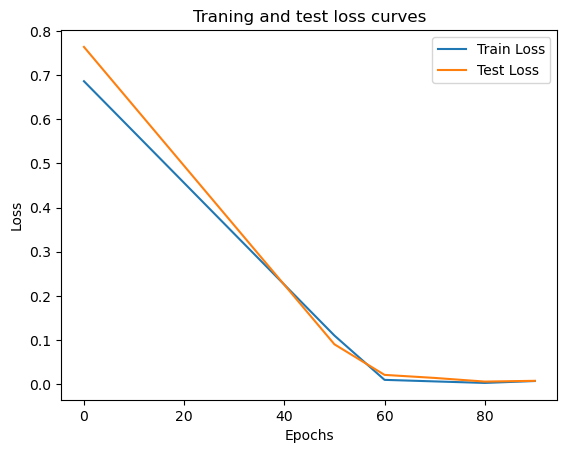

In [16]:
plt.plot(epoch_count, train_lost_values, label = "Train Loss")
plt.plot(epoch_count, test_loss_values, label = "Test Loss")
plt.title("Traning and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()



In [17]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6977])), ('bias', tensor([0.3080]))])

In [18]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

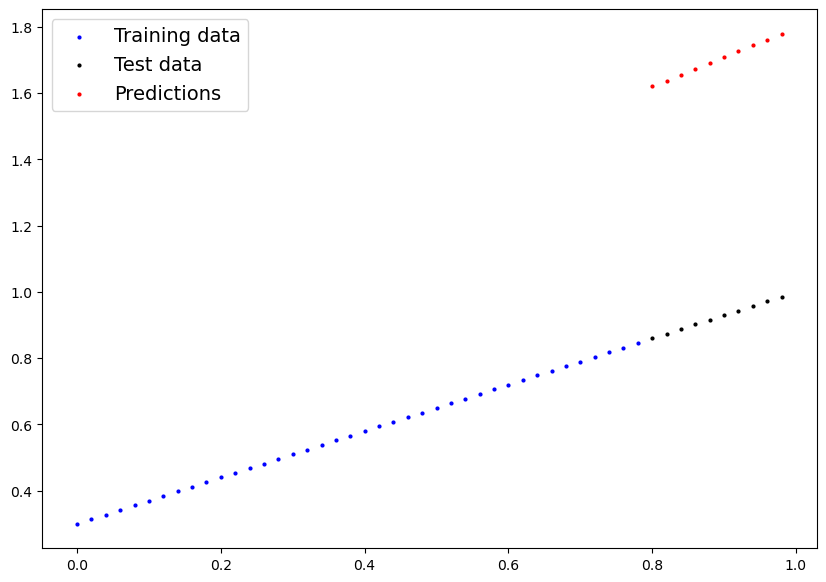

In [19]:
plot_predictions(predictions=y_preds)

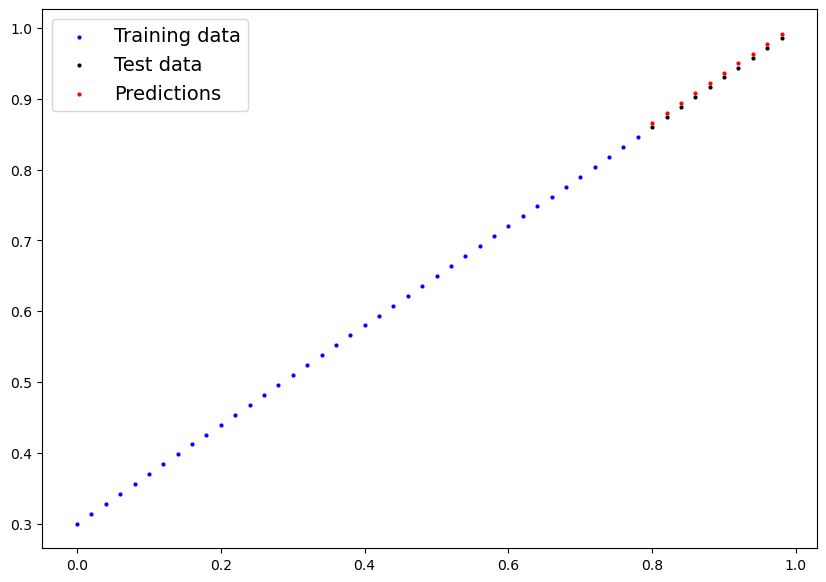

In [20]:
plot_predictions(predictions=y_preds_new)

In [ ]:
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("Original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

## 5. Saving a Model in PyTorch

There are three main methods for saving and loading models in PyTorch.

1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary 

In [21]:
# Saving the PyTorch model

from pathlib import Path

# 1. Create Model Directory

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a Model save Path

MODEL_NAME = "workflow_model0.path"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_0.state_dict(), f = MODEL_SAVE_PATH)


Saving model to: models/workflow_model0.path


In [22]:
# Loading a PyTroch model

# we saved the model's state dict rather that the entire model, we'll create a new instance of our model class and load the saved state dict into that

# Instantiate a new instance of the model class

loaded_model_0 = LinearRegressionModel()

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [23]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6977])), ('bias', tensor([0.3080]))])